In [1]:
suppressPackageStartupMessages({
  library(dplyr)
  library(pagoda2)
  library(cowplot)
  library(magrittr)
  library(dataorganizer)
  library(ggrastr)
  library(readr)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
# load up the spatial data
cell_annot <- prepare_nsclc_metadata(reps='one')
df <- prepare_nsclc_transcript_data(cell_annot, reps='one')

In [3]:
# load and process the precomputed DE results
spatial_genes <- unique(df$gene)
de_res <- DatasetPath("nsclc_rna", "markers.csv") %>% read.csv()
de_res$cluster <- sapply(de_res$cluster, \(x){
  if (x=='tumor') 'malignant' else x
})

# removing cell types not found in spatial data
ct_annot_spatial <- DatasetPath('nsclc_lung5_1', 'annotation_adj.csv') %>% read.csv()
ct_keep <- c(unique(ct_annot_spatial$cell_type), 'malignant')
de_res <- de_res[de_res$cluster %in% ct_keep,]

print(head(de_res))

  p_val avg_log2FC pct.1 pct.2 p_val_adj      cluster   Gene       AUC
1     0   3.359284 0.642 0.118         0 CD4+ T cells   IL7R 0.7616765
2     0  -5.328028 0.029 0.452         0 CD4+ T cells TYROBP 0.2884849
3     0   2.099673 0.555 0.165         0 CD4+ T cells   ETS1 0.6952165
4     0   2.650509 0.477 0.090         0 CD4+ T cells SPOCK2 0.6932298
5     0   1.361107 0.833 0.459         0 CD4+ T cells  CXCR4 0.6871201
6     0   1.986352 0.514 0.164         0 CD4+ T cells    FYN 0.6747221
  Specificity  Precision ExpressionFraction
1   0.8900617 0.53603682         0.64168399
2   0.6252661 0.01357422         0.02920998
3   0.8493020 0.41768293         0.55540541
4   0.9187024 0.52924888         0.47681913
5   0.5566131 0.27887157         0.83336798
6   0.8509502 0.39964433         0.51392931


In [4]:
# select marker genes from the cluster DE results
ct_all <- unique(de_res$cluster)
marker_res_all <- list()
for (ct in ct_all) {
    marker.genes <- select_markers_nsclc(de_res,ct)
    de_res_sub <- de_res[de_res$cluster==ct,]
    de_res_sub <- de_res_sub[de_res_sub$Gene %in% marker.genes,]
    rownames(de_res_sub) <- de_res_sub$Gene
    marker_res_all[[ct]] <- de_res_sub
}
marker_res2 <- do.call(rbind.data.frame,marker_res_all)
print(head(marker_res2))

DatasetPath('nsclc_rna', 'nsclc_markers_list_full.tsv') %>%
  {write.table(marker_res2, ., quote=FALSE, row.names=FALSE, sep='\t')}

                 p_val avg_log2FC pct.1 pct.2 p_val_adj  cluster    Gene
monocyte.RXRA        0   1.272395 0.419 0.090         0 monocyte    RXRA
monocyte.TLR2        0   1.316015 0.369 0.067         0 monocyte    TLR2
monocyte.BST1        0   1.594493 0.257 0.042         0 monocyte    BST1
monocyte.CLEC12A     0   2.907821 0.232 0.020         0 monocyte CLEC12A
monocyte.NOTCH2      0   1.362193 0.276 0.064         0 monocyte  NOTCH2
monocyte.NLRP3       0   2.746804 0.238 0.031         0 monocyte   NLRP3
                       AUC Specificity Precision ExpressionFraction
monocyte.RXRA    0.6644662   0.9125675 0.1845807          0.4188337
monocyte.TLR2    0.6508277   0.9348589 0.2106685          0.3687943
monocyte.BST1    0.6073028   0.9591841 0.2278923          0.2568952
monocyte.CLEC12A 0.6063644   0.9809719 0.3639729          0.2324665
monocyte.NOTCH2  0.6060861   0.9385275 0.1739563          0.2758077
monocyte.NLRP3   0.6034215   0.9703526 0.2729742          0.2375887


In [5]:
sc_obj <- load_scrnaseq_matrix_nsclc()
sc_obj[['RNA']]$data <- log1p(sc_obj[['RNA']]$counts)

ct_levels <- c(
  'malignant','fibroblast','macrophage','monocyte','DC','mast',
  'Treg','CD4+ T cells','CD8+ T cells', 'NK','B cells',
  'plasmablast','neutrophil', 'endothelial','epithelial'
)

Idents(sc_obj) <- factor(sc_obj$cell_type, levels=ct_levels)

table(Idents(sc_obj))

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 17.1 GiB”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”



   malignant   fibroblast   macrophage     monocyte           DC         mast 
        3694          585         6497         2538         2125          732 
        Treg CD4+ T cells CD8+ T cells           NK      B cells  plasmablast 
         951         9620         4157         2622         5364         2208 
  neutrophil  endothelial   epithelial 
       11639          535          449 

In [6]:
# convert spatial data to counts form
so_spat <- get_counts_meta_seurat(df)
dat_orig <- so_spat[['RNA']]$counts
meta_orig <- so_spat@meta.data

# reduce to same cell types as in the scRNA data
cells_keep <- rownames(meta_orig)[meta_orig$cell_type %in% unique(as.character(sc_obj$cell_type))]
meta_orig <- meta_orig[cells_keep,]
dat_orig <- dat_orig[,cells_keep]
table(meta_orig$cell_type)


     B cells CD4+ T cells CD8+ T cells           DC  endothelial   epithelial 
        7207         7993         1338         7088         7613         4098 
  fibroblast   macrophage    malignant         mast     monocyte   neutrophil 
       13151         7409        18600         2462         1843         9925 
          NK  plasmablast         Treg 
        1668         7079          528 

In [7]:
# Select top markers from our three example cell types to show in the dotplot
marker_res2 <- marker_res2[order(marker_res2$AUC,decreasing=TRUE),]
markers_plot <- lapply(c('malignant','fibroblast','macrophage'),function(ct) {
  marker_genes_sub <- marker_res2[marker_res2$cluster==ct,]
  if (ct %in% c('malignant','fibroblast','macrophage')) {
    if (length(marker_genes_sub$Gene) > 5) {
      return(marker_genes_sub$Gene[1:5])
    } else {
      return(marker_genes_sub$Gene)
    }
  }
})
markers_plot <- unique(unlist(markers_plot))
markers_plot <- rev(markers_plot)
markers_plot

[1] "OLR1"    "CD163"   "C1QB"    "MRC1"    "C1QA"    "COL6A3"  "COL3A1" 
 [8] "COL1A2"  "DCN"     "LUM"     "CEACAM6" "TACSTD2" "KRT18"   "KRT19"  
[15] "KRT8"

Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


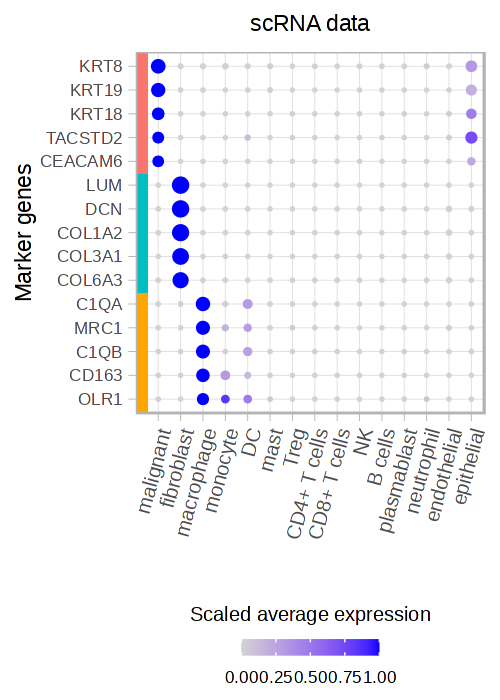

In [8]:
options(repr.plot.width = 2.5, repr.plot.height = 3.5, repr.plot.res = 200)

##### making version to show the average log(cpm+1)
p <- DotPlot(object = sc_obj, features = markers_plot,
            col.min = 0,col.max = 5)

p$data$avg.exp.scaled <- NA
p_dat_lst <- lapply(markers_plot,function(g) {
  p_dat_sub <- p$data[p$data$features.plot==g,]
  X <- p_dat_sub$avg.exp
  min_val <- min(X)
  max_val <- max(X)
  X_std = (X - min_val) / (max_val - min_val)
  p_dat_sub$avg.exp.scaled <- X_std
  return(p_dat_sub)
})

p_dat_lst2 <- do.call(rbind.data.frame,p_dat_lst)

p$data <- p_dat_lst2

p$layers[[1]] <- NULL

sep_ndx1 <- length(markers_plot) - 9.5
sep_ndx2 <- length(markers_plot) - 4.5

p_sc <- p +
  geom_point(mapping=aes(size=pct.exp, color=avg.exp.scaled)) + # change to avg.exp.log or avg.exp.log.scaled or avg.exp.scaled
  coord_flip() +
  xlab('Marker genes') +
  ylab('') +
  ggtitle('scRNA data') +
  theme_light(base_line_size = gg_line_thickness) +
  scale_radius(range = c(0,2)) +
  p_theme +
  theme(
    axis.text.x = element_text(angle = 75, vjust = 1, hjust=1, size=7),
    axis.text.y = element_text(size=6),
    legend.key.size = unit(6, 'pt'),
    legend.key.height = unit(6, 'pt'),
    legend.key.width = unit(10, 'pt'),
    legend.title=element_text(size=7),
    legend.text=element_text(size=6),
    legend.position="bottom",
    legend.box="vertical", legend.margin=margin()) +
  guides(
    colour = guide_colourbar(title.position="top", title.hjust = 0.5),
    size = 'none'
  ) +
  labs(colour="Scaled average expression") +
  annotate(
    ymin = 0, ymax = .5, # width
    xmin = c(-Inf,sep_ndx1,sep_ndx2), xmax = c(sep_ndx1,sep_ndx2,Inf), # height for each section
    geom = "rect",
    fill = c("orange", "#00BFC4", "#F8766D")
  )

p_sc

In [9]:
# prep spatial data as seurat object
seurat_spatial <- CreateSeuratObject(dat_orig,meta.data = meta_orig)
seurat_spatial <- NormalizeData(seurat_spatial)
Idents(seurat_spatial) <- factor(seurat_spatial$cell_type, levels=ct_levels)

Normalizing layer: counts



Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”
Scale for size is already present.
Adding another scale for size, which will replace the existing scale.


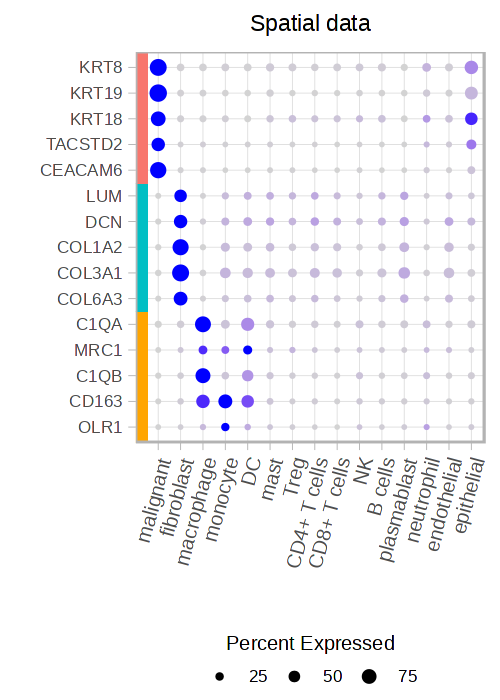

In [10]:
options(repr.plot.width = 2.5, repr.plot.height = 3.5, repr.plot.res = 200)

##### making version to show the average log(cpm+1)
p <- DotPlot(object = seurat_spatial, features = markers_plot,
            col.min = 0,col.max = 5)

p$data$avg.exp.scaled <- NA
p_dat_lst <- lapply(markers_plot,function(g) {
  p_dat_sub <- p$data[p$data$features.plot==g,]
  X <- p_dat_sub$avg.exp
  min_val <- min(X)
  max_val <- max(X)
  X_std = (X - min_val) / (max_val - min_val)
  p_dat_sub$avg.exp.scaled <- X_std
  return(p_dat_sub)
})

p_dat_lst2 <- do.call(rbind.data.frame,p_dat_lst)

p$data <- p_dat_lst2

p$layers[[1]] <- NULL

sep_ndx1 <- length(markers_plot) - 9.5
sep_ndx2 <- length(markers_plot) - 4.5

p_spat <- p +
  geom_point(mapping = aes_string(size = 'pct.exp', color = 'avg.exp.scaled')) +
  coord_flip() +
  xlab('') +
  ylab('') +
  ggtitle('Spatial data') +
  theme_light(base_line_size = gg_line_thickness) +
  scale_radius(range = c(0,2)) +
  p_theme +
  theme(
    axis.text.x = element_text(angle = 75, vjust = 1, hjust=1, size=7),
    axis.text.y = element_text(size=6),
    legend.key.size = unit(6, 'pt'),
    legend.key.height = unit(6, 'pt'),
    legend.key.width = unit(10, 'pt'),
    legend.title=element_text(size=7),
    legend.text=element_text(size=6),
    legend.position="bottom",
    legend.box="vertical", legend.margin=margin()) +
    guides(colour = 'none',
    size = guide_legend(title.position="top", title.hjust = 0.5)
  ) +
  labs(size="Percent Expressed") +
  annotate(
    ymin = 0, ymax = .5, # width
    xmin = c(-Inf,sep_ndx1,sep_ndx2), xmax = c(sep_ndx1,sep_ndx2,Inf), # height for each section
    geom = "rect",
    fill = c("orange", "#00BFC4", "#F8766D")
  )

p_spat

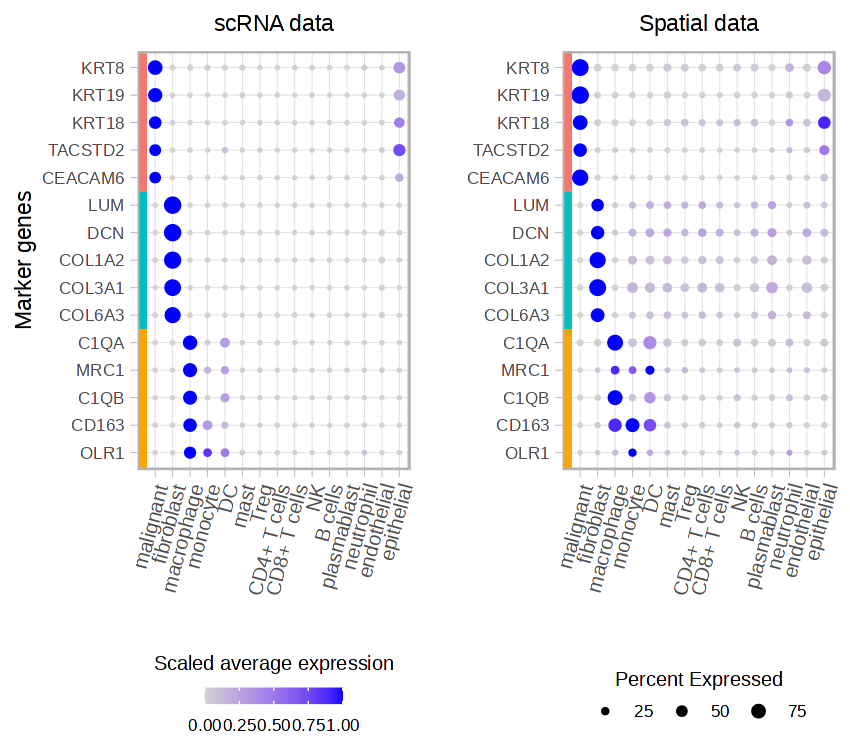

In [11]:
# options(repr.plot.width = 4.15, repr.plot.height = 3.25, repr.plot.res = 200)
options(repr.plot.width = 4.25, repr.plot.height = 3.75, repr.plot.res = 200)

fig <- cowplot::plot_grid(p_sc,p_spat,nrow=1,align='hv')
fig

In [12]:
pdf(OutputPath("nsclc_sc_spatial_marker_dotplots.pdf"), useDingbats=FALSE, width=4.25, height=3.75)
fig
dev.off()

png 
  2